# EDA on youtuber Hasan Pikers (HasanAbi) comment section

I've used YouTube's API to extract data from the comment section of political commentator Hasan Piker, joining with a data table extracted from the profiles of the commenters

>The particular video chosen is titled 'What Happened Last Night...' and is a response to the 2024 General Election

In [303]:
import warnings
warnings.filterwarnings('ignore')

## Utility Functions

In [35]:
import csv

# Import data to CSV
def to_csv(csv_file, header_list, data):
    with open(csv_file, "w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(header_list) # Header row
        writer.writerows(data) # Data rows

## Extracting Data from HasanAbi comments

In [150]:
from apiclient.discovery import build

# creating youtube resource object
youtube = build('youtube','v3',
                developerKey="")

nextPg = ""
data=[]

# Number of rows to extract
x=100
headers = ['textOriginal','authorDisplayName','likeCount','publishedAt']
while True and x>0:
    video_response=youtube.commentThreads().list(part='snippet',videoId='jq35lZtdXws',pageToken=nextPg).execute()
    for item in video_response['items']:
        block = item['snippet']['topLevelComment']['snippet']
        page_data = []
        for head in headers:
            page_data.append(str(block[head]))
        page_data.append(item['snippet']['totalReplyCount'])
        page_data.append(item['snippet']['topLevelComment']['snippet']['authorChannelId']['value'])
        data.append(page_data)

    # Pagination
    if (video_response.get('nextPageToken') != ''):
        nextPg = video_response.get('nextPageToken')
        x = x-1
    else:
        break
        
headers.append('totalReplyCount')
headers.append('authorChannelId')
print("All done!")
to_csv('youtubehasan.csv', headers, data)


All done!


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

youtube_comments = pd.read_csv('youtubehasan.csv')

print("Number of comments: ", len(youtube_comments))


Number of comments:  1998


## Top 5 Comments by Likes

In [275]:
youtube_comments_sorted = youtube_comments.sort_values(by='likeCount', ascending=False).iloc[:5]
youtube_comments_sorted[['textOriginal','likeCount']].style

,textOriginal,likeCount
1596,Americans are not beating the dumbest people allegations,7811
1593,"Red legislative branch, red executive branch, and red judicial branch. We’re fucked for multiple generations to come",7348
1472,"Libs campaigning as ""we are Republicans too"" was very effective at making a Republican candidate appealing.",5345
1555,This is what happens when education can’t be afforded by most of the country,3909
1600,The Supreme Court will be lost for decades we may never get it to swing left again.,2898


## Top 5 Comments by Replies

In [277]:
youtube_comments_sorted_rply = youtube_comments.sort_values(by='totalReplyCount', ascending=False).iloc[:5]
youtube_comments_sorted_rply[['textOriginal','totalReplyCount']].style

,textOriginal,totalReplyCount
1593,"Red legislative branch, red executive branch, and red judicial branch. We’re fucked for multiple generations to come",209
1588,I hate America.,163
1596,Americans are not beating the dumbest people allegations,150
1660,"I’m a single, childless, woman with a disabled mother I live with and take care of….America told me I don’t matter. I’m devastated. I don’t know what to do. I’m going to lose everything.",144
1669,"German here, terrified and disgusted. Sending lots of love and strength to you guys. We're all gonna need it. Jesus Christ.",103


## Extracting Data from Commenters Profiles 

In [ ]:
id_list = youtube_comments['authorChannelId'].tolist()
headers_id = ['id','subscriberCount','videoCount']
data_id=[]
for id_name in id_list:
    channel_data = youtube.channels().list(part="statistics", id=id_name).execute()
    page_data_id=[channel_data['items'][0]['id'],channel_data['items'][0]['statistics']['subscriberCount'],channel_data['items'][0]['statistics']['videoCount']]
    data_id.append(page_data_id)
print("All Done!")

to_csv('youtubeidstats.csv', headers_id, data_id)

## Joining together the two data frames and cleaning up

In [7]:
id_df = pd.read_csv('youtubeidstats.csv')
id_df.rename({'id': 'authorChannelId'}, axis=1, inplace=True)

youtube_merged = pd.merge(youtube_comments, id_df.drop_duplicates(subset=['authorChannelId']), on='authorChannelId', how='inner')
youtube_merged = youtube_merged.drop(youtube_merged[youtube_merged.duplicated(keep=False)].index)

In [283]:
youtube_merged.sort_values(by='subscriberCount',ascending=False).head()

,textOriginal,authorDisplayName,likeCount,publishedAt,totalReplyCount,authorChannelId,subscriberCount,videoCount
1682,Harambe dies 2016: Trump elected.\nPeanut dies...,@TurtleChad1,965,2024-11-06T13:43:58Z,23,UCOAmvK5o2JmH0vXi3Ql_qWg,24800,47
1532,Thank fucking God I'm Canadian,@themetalmeltdownofficial,17,2024-11-06T13:53:52Z,9,UC6DrrBx7gJ5fKAJFN0p19Ng,18900,1165
1209,"Looking forward to 4 years of the dumbest, mos...",@valianes,0,2024-11-06T14:37:17Z,0,UCtetZ0I01-v04Ishks7nBZQ,8370,30
1590,"The world is watching as once again, the Muric...",@KategariYami,68,2024-11-06T13:49:13Z,3,UCAyopdck5m4z9at_Nyi0cgQ,6620,2488
387,What happened last night Americans ate their o...,@BushidoXBrown,1,2024-11-06T18:01:16Z,0,UCfajsC8T8JlrRg89675NqyA,6140,837


In [168]:
youtube_merged['publishedAt']= pd.to_datetime(youtube_merged['publishedAt'])
youtube_merged.dtypes

textOriginal                      object
authorDisplayName                 object
likeCount                          int64
publishedAt          datetime64[ns, UTC]
totalReplyCount                    int64
authorChannelId                   object
subscriberCount                    int64
videoCount                         int64
dtype: object

## Correlation matrix

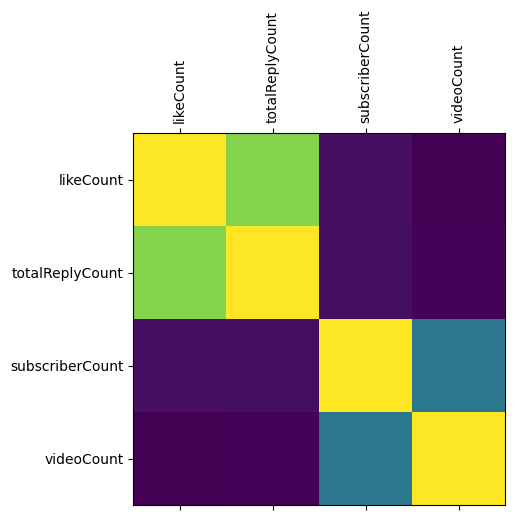

In [287]:
x = youtube_merged[['likeCount','totalReplyCount','subscriberCount','videoCount']]
plt.matshow(x.corr())
plt.xticks(ticks=range(0,4),labels=x, rotation ='vertical')
plt.yticks(ticks=range(0,4),labels=x, rotation = 'horizontal')
plt.show()

## Regression

#### I want to analyze the relationship between the number of likes on the comment and the number of subscribers that account has

In [175]:
import statsmodels.api as sm

X = youtube_merged[['subscriberCount']] 
y = youtube_merged['likeCount'] 
X = sm.add_constant(X)

lr_model_youtube = sm.OLS(y,X).fit()

print(lr_model_youtube.summary())
print(lr_model_youtube.params)

                            OLS Regression Results                            
Dep. Variable:              likeCount   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.703
Date:                Thu, 12 Dec 2024   Prob (F-statistic):              0.100
Time:                        13:51:31   Log-Likelihood:                -10432.
No. Observations:                1418   AIC:                         2.087e+04
Df Residuals:                    1416   BIC:                         2.088e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              43.0600     10.143     

Intercept:  43.06003601598557
Coefficients of x:  [0.0178255]


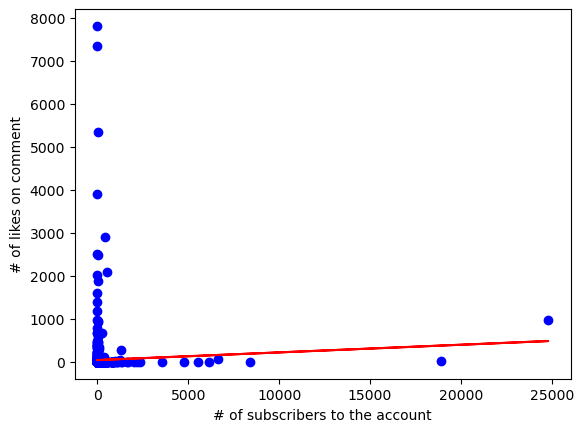

In [186]:
from sklearn.linear_model import LinearRegression

X = youtube_merged[['subscriberCount']] 
y = youtube_merged['likeCount'] 

model = LinearRegression()
model.fit(X, y)

predictions = model.predict(X)
print('Intercept: ', model.intercept_)
print('Coefficients of x: ', model.coef_)

plt.scatter(youtube_merged['subscriberCount'],youtube_merged['likeCount'], color='blue')
plt.plot(youtube_merged['subscriberCount'], predictions,color='red')
plt.xlabel('# of subscribers to the account')
plt.ylabel('# of likes on comment')
plt.show()


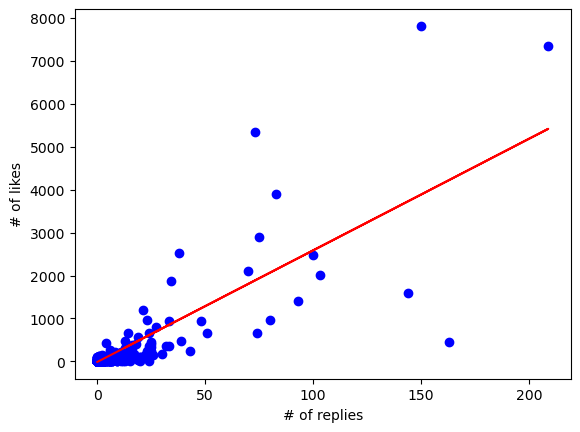

In [211]:
X_reply = youtube_merged[['totalReplyCount']] 
y_reply = youtube_merged['likeCount'] 

model = LinearRegression()
model.fit(X_reply, y_reply)

predictions = model.predict(X_reply)

plt.scatter(X_reply,y_reply, color='blue')
plt.plot(X_reply, predictions,color='red')
plt.xlabel('# of replies')
plt.ylabel('# of likes')
plt.show()

## Sentiment Analysis

In [11]:
from textblob import TextBlob

youtube_merged[['polarity', 'subjectivity']] = youtube_merged['textOriginal'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

youtube_merged[['textOriginal','polarity','totalReplyCount']].sort_values(by='totalReplyCount',ascending=False).head().style

,textOriginal,polarity,totalReplyCount
1593,"Red legislative branch, red executive branch, and red judicial branch. We’re fucked for multiple generations to come",-0.120000,209
1588,I hate America.,-0.800000,163
1596,Americans are not beating the dumbest people allegations,0.000000,150
1660,"I’m a single, childless, woman with a disabled mother I live with and take care of….America told me I don’t matter. I’m devastated. I don’t know what to do. I’m going to lose everything.",-0.045022,144
1669,"German here, terrified and disgusted. Sending lots of love and strength to you guys. We're all gonna need it. Jesus Christ.",-0.166667,103


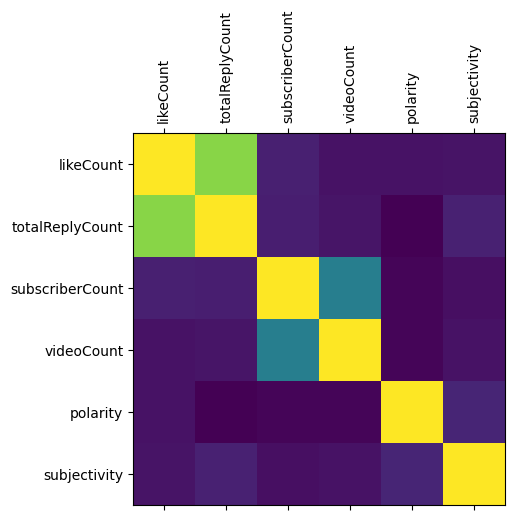

In [13]:
x_sentiment = youtube_merged[['likeCount','totalReplyCount','subscriberCount','videoCount','polarity','subjectivity']]
plt.matshow(x_sentiment.corr())
plt.xticks(ticks=range(0,6),labels=x_sentiment, rotation ='vertical')
plt.yticks(ticks=range(0,6),labels=x_sentiment, rotation = 'horizontal')
plt.show()

## Word Cloud of most used words in comments

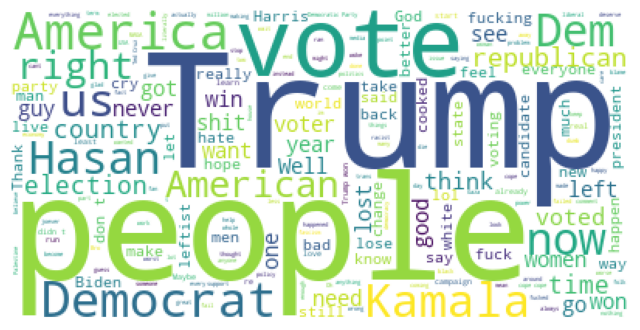

In [377]:
from wordcloud import WordCloud, STOPWORDS
comment_string = youtube_merged.apply(lambda row: f" {row['textOriginal']}", axis=1).str.cat()

stop_words = set(STOPWORDS)
stop_words.update(["s", "will", 'even','gonna','thing','going','u','m'])

wc = WordCloud(stopwords=stop_words, background_color="white").generate(comment_string)
plt.figure(figsize=(8, 6))
plt.imshow(wc)
plt.axis("off")
plt.show()

## Conclusion

#### The highest correlation was between reply count and like count, which is to be expected
#### There is a slight correlation between subjectivity and reply count
#### I did not find a correlation between subscriber count and like or reply count on the comments